In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import pickle

In [3]:
proj_name = "cross_tissue_Eraslan"
file_name = "cross_tissue_Eraslan"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

ccd.ul.set_seed(seed)

In [4]:
adata =  sc.read_h5ad(data_dir / f"{file_name}_final.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 208812 × 32839
    obs: 'Sample ID_prep', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'n_genes', 'fpr', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sample ID', 'donor_id', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'scrublet', 'scrublet_score', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'channel', 'developm

# upload obsm from h5 file

In [6]:
import h5py

h5_path = "../save/obsm_concord-1.0.3_Jul03/obsm_cross_tissue_Eraslan_Jul05-2248.h5"

def print_h5_structure(g, prefix=""):
    for key in g.keys():
        item = g[key]
        if isinstance(item, h5py.Group):
            print(f"{prefix}{key}/ (Group)")
            print_h5_structure(item, prefix=prefix + key + "/")
        elif isinstance(item, h5py.Dataset):
            print(f"{prefix}{key:50s} shape: {item.shape}")

with h5py.File(h5_path, 'r') as f:
    print_h5_structure(f)

obsm/ (Group)
obsm/X_pca                                              shape: (208812, 50)
obsm/X_umap                                             shape: (208812, 2)
obsm/X_vae_mean                                         shape: (208812, 64)
obsm/X_vae_samples                                      shape: (208812, 64)
obsm/X_vae_var                                          shape: (208812, 64)
obsm/concord_hcl                                        shape: (208812, 50)
obsm/concord_hcl_UMAP                                   shape: (208812, 2)
obsm/concord_hcl_UMAP_3D                                shape: (208812, 3)
obsm/concord_knn                                        shape: (208812, 50)
obsm/concord_knn_UMAP                                   shape: (208812, 2)
obsm/concord_knn_UMAP_3D                                shape: (208812, 3)
obsm/contrastive                                        shape: (208812, 50)
obsm/contrastive_UMAP                                   shape: (208812, 2)
obsm

In [7]:
obsm_keys_to_copy = [
    "contrastive_UMAP", "contrastive_UMAP_3D",
    "harmony_UMAP", "harmony_UMAP_3D",
    "scanorama_UMAP", "scanorama_UMAP_3D",
    "scvi_UMAP", "scvi_UMAP_3D",
    "unintegrated_UMAP", "unintegrated_UMAP_3D",
    # "liger_UMAP", "liger_UMAP_3D",
]

In [8]:
with h5py.File(h5_path, 'r') as f:
    obsm_group = f['obsm']
    for key in obsm_keys_to_copy:
        if key in obsm_group:
            data = obsm_group[key][:]
            assert data.shape[0] == adata.n_obs, f"Shape mismatch for {key}"
            print(f"✅ Appending: {key}")
            adata.obsm[key] = data
        else:
            print(f"⚠️  Skipped (not found): {key}")

✅ Appending: contrastive_UMAP
✅ Appending: contrastive_UMAP_3D
✅ Appending: harmony_UMAP
✅ Appending: harmony_UMAP_3D
✅ Appending: scanorama_UMAP
✅ Appending: scanorama_UMAP_3D
✅ Appending: scvi_UMAP
✅ Appending: scvi_UMAP_3D
✅ Appending: unintegrated_UMAP
✅ Appending: unintegrated_UMAP_3D


In [38]:
adata.write(data_dir / f"{file_name}_final.h5ad")

In [10]:
adata

AnnData object with n_obs × n_vars = 208812 × 32839
    obs: 'Sample ID_prep', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'n_genes', 'fpr', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sample ID', 'donor_id', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'scrublet', 'scrublet_score', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'channel', 'developm

----

# time and memory profiling

In [4]:
methods = ["unintegrated", "liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

✅ Benchmark summary saved to: ../save/cross_tissue_Eraslan-Jul28-1548/benchmark_summary_Jul28-1548.tsv


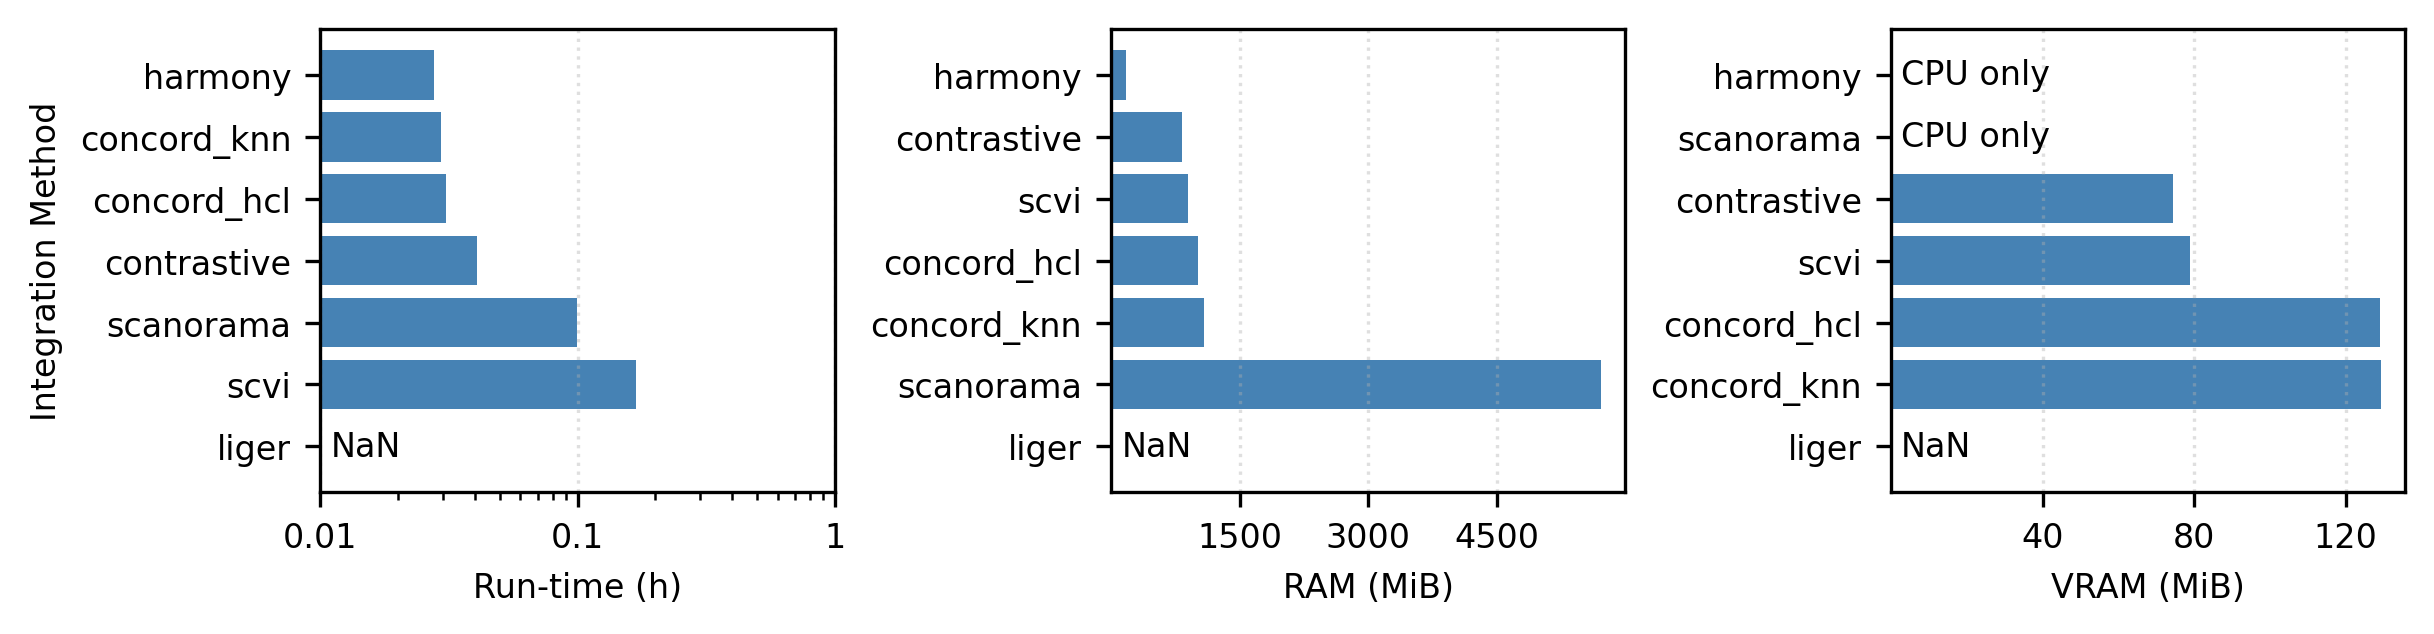

In [5]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs(proj_name, methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, 
                               save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf",
                               label_fontsize=8)


In [37]:
bench_df

,method,gpu_name,time_sec,ram_MB,vram_MB
0,liger,Tesla T4,NaN,NaN,NaN
1,harmony,Tesla T4,99.147545,176.511719,0.000000
2,scanorama,Tesla T4,356.766477,5707.636719,0.000000
3,scvi,Tesla T4,609.883795,899.890625,78.780273
4,contrastive,Tesla T4,146.655514,833.363281,74.510254
5,concord_knn,Tesla T4,106.105374,1087.105469,129.163086
6,concord_hcl,Tesla T4,110.782367,1011.859375,129.084961


----

# UMAP

In [29]:
methods = ["unintegrated", "liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

batch_key = 'batch'
state_key = 'cell_type'

In [34]:
adata.obs['batch'] = adata.obs['batch'].astype(str).astype('category')


concord.plotting.pl_embedding - INFO - Plotting unintegrated with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting scvi with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with batch in UMAP


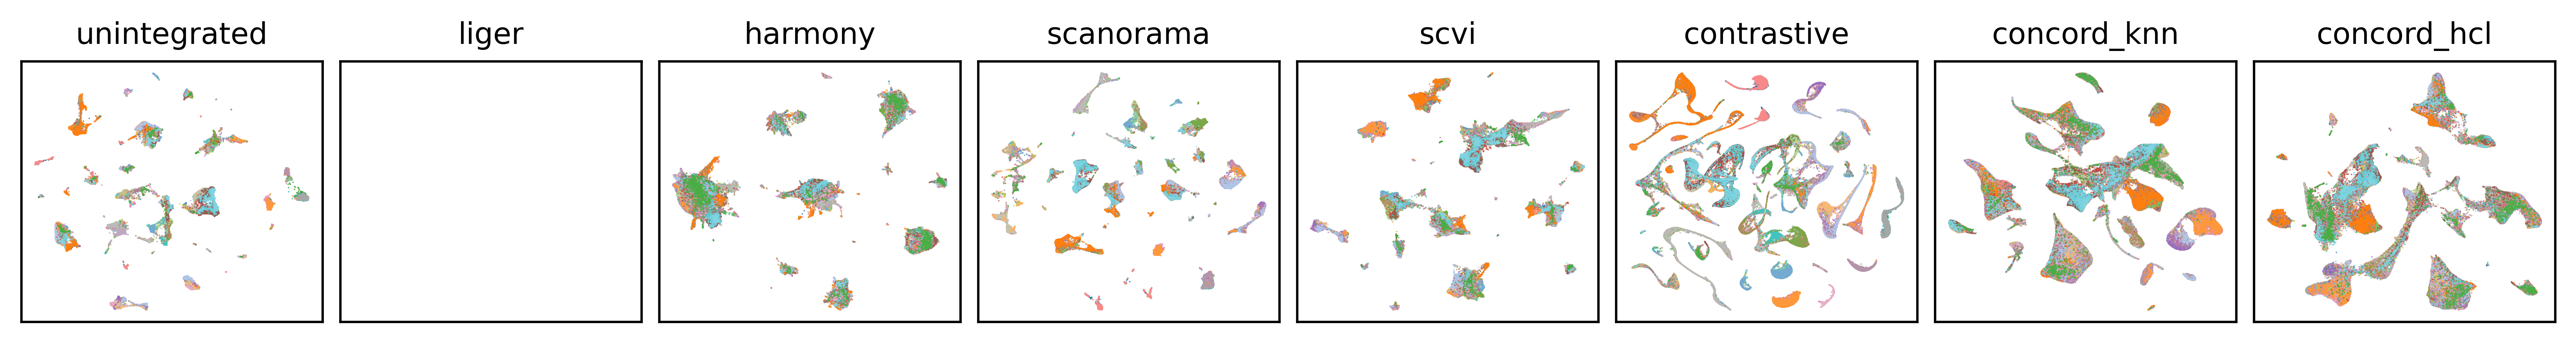

concord.plotting.pl_embedding - INFO - Plotting unintegrated with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting scvi with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with cell_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with cell_type in UMAP


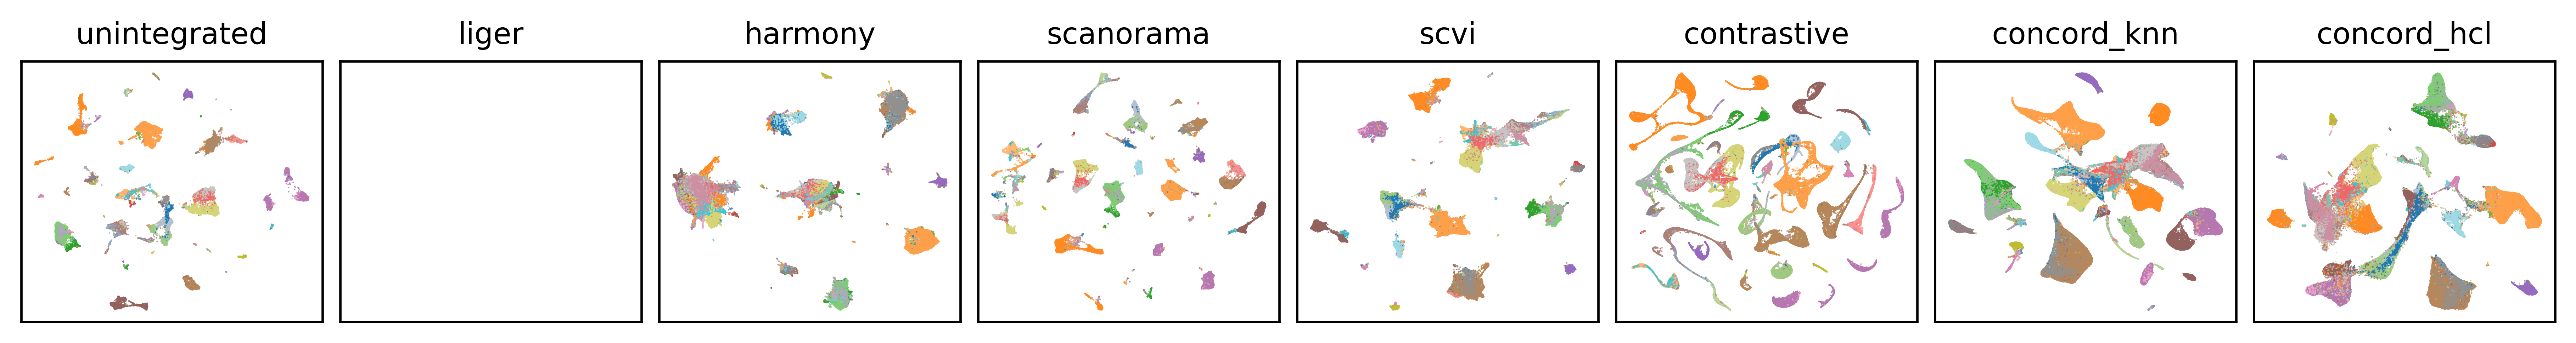

In [42]:
# plot everything
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns

# Set DejaVu Sans as the default font
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}

show_keys = methods
show_cols = [batch_key, state_key]
basis_types = ['UMAP']

font_size=10
point_size=1
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {}
for key in [batch_key, state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )
